In [92]:
%matplotlib inline

import copy
from datetime import date
from IPython.display import display
import json
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
import time
import torch as pt
from tqdm import tqdm

sys.path.insert(0, '..')

from numpy import exp, log
from scipy.linalg import expm, inv, solve_banded

from utilities import plot_control_for_DoubleWell1d, plot_loss_logs, do_importance_sampling, save_exp_logs
from problems import LLGC, DoubleWell, LQGC
from function_space import DenseNet, Linear, NN, NN_Nik, SingleParam, MySequential
from solver import Solver


%load_ext autoreload
%autoreload 2

device = pt.device('cuda')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
dw = DoubleWell(T=1, eta=3.0, kappa=5.0)
dw.compute_reference_solution()

In [3]:
# overwrite train method to account for the computation of the gradient variance

class Solver_grad(Solver):
    
    def train(self):

        pt.manual_seed(self.seed)

        if self.verbose is True:
            print('d = %d, L = %d, K = %d, delta_t = %.2e, lr = %.2e, %s, %s, %s, %s'
                  % (self.d, self.L, self.K, self.delta_t_np, self.lr, self.approx_method,
                     self.time_approx, self.loss_method,
                     'adaptive' if self.adaptive_forward_process else ''))

        for l in range(self.L):
            t_0 = time.time()

            for m in range(self.M):

                X, Y, Z_sum, u_L2, u_int, u_W_int, double_int, xi = self.initialize_training_data()
                additional_loss = pt.zeros(self.K)

                for n in range(self.N):
                    if self.approx_method == 'value_function':
                        if n > 0:
                            additional_loss += (self.Y_n(X, n)[:, 0] - Y).pow(2)
                    Z = self.Z_n_(X, n)

                    c = pt.zeros(self.d, self.K).to(device)
                    if self.adaptive_forward_process is True:
                        c = -Z.t()
                    if self.detach_forward is True:
                        c = c.detach()
                    X = (X + (self.b(X) + pt.mm(self.sigma(X), c).t()) * self.delta_t
                         + pt.mm(self.sigma(X), xi[:, :, n + 1].t()).t() * self.sq_delta_t)
                    Y = (Y + (self.h(self.delta_t * n, X, Y, Z) + pt.sum(Z * c.t(), 1)) * self.delta_t
                         + pt.sum(Z * xi[:, :, n + 1], dim=1) * self.sq_delta_t)

                    Z_sum += 0.5 * pt.sum(Z**2, 1) * self.delta_t
                    if self.loss_method == 'relative_entropy_BSDE':
                        Z_sum +=  pt.sum(Z * xi[:, :, n + 1], 1) * self.sq_delta_t

                    if self.u_l2_error_flag is True:
                        u_L2 += pt.sum((-Z
                                        - pt.tensor(self.u_true(X.cpu().detach(), n * self.delta_t_np)).t().float().to(device))**2
                                       * self.delta_t, 1)

                # self.log_Z_log.append(pt.mean((Y - self.g(X))).item())
                
                if self.compute_gradient_variance > 0 and l % self.compute_gradient_variance == 0:
                    self.grads_rel_error_log.append(pt.mean(self.get_gradient_variances(X, Y)).item())
                
                self.zero_grad()
                loss = self.loss_function(X, Y, Z_sum, l) + additional_loss.mean()
                loss.backward()
                if m == self.M - 1:
                    self.optimization_step()

                grads = [params.grad for params in list(filter(lambda params: params.requires_grad, self.z_n.parameters()))
                        if params.grad is not None]
                grads_flat = pt.zeros(self.p)        
                i = 0
                for grad in grads:
                    grad_flat = grad.reshape(-1)
                    j = len(grad_flat)
                    grads_flat[i:i + j] = grad_flat
                    i += j

                self.gradient_log[l, m, :] = grads_flat.cpu().detach()

            self.loss_log.append(loss.item())
            self.u_L2_loss.append(pt.mean(u_L2).item())
            if self.metastability_logs is not None:
                target, epsilon = self.metastability_logs
                self.particles_close_to_target.append(pt.mean((pt.sqrt(pt.sum((X - target)**2, 1)) <
                                                               epsilon).float()))

            if self.IS_variance_K > 0 and l % self.IS_variance_iter == 0:
                _, _, rel_naive, _, _, rel_IS = do_importance_sampling(self.problem, self,
                                                                                 self.IS_variance_K,
                                                                                 control='approx',
                                                                                 verbose=False,
                                                                                 plot_trajectories=self.plot_trajectories)
                self.IS_rel_log.append(rel_IS)

            
            t_1 = time.time()
            self.times.append(t_1 - t_0)
            
            if self.verbose is True:
                if l % self.print_every == 0:
                    string = ('%d - loss: %.4e - u L2: %.4e - time/iter: %.2fs'
                              % (l, self.loss_log[-1], self.u_L2_loss[-1],
                                 np.mean(self.times[-self.print_every:])))
                    if self.IS_variance_K > 0:
                        string += ' - rel naive: %.3e - rel IS: %.3e' % (rel_naive, rel_IS)
                    print(string)
                    print('gradient l_inf: %.3e' %
                          (np.array([max([pt.norm(params.grad.data, float('inf')).item() for params in
                                          filter(lambda params: hasattr(params.grad, 'data'),
                                                 phi.parameters())])
                                     for phi in self.Phis]).max()))

            if self.early_stopping_time is not None:
                if ((l > self.early_stopping_time) and
                        (np.std(self.u_L2_loss[-self.early_stopping_time:])
                         / self.u_L2_loss[-1] < 0.02)):
                    break

        if self.save_results is True:
            self.save_logs()

In [ ]:
seed = 42
lr = 0.05
K = 500
L = 1000
print_every = 100
M = 50
delta_t = 0.005
IS_variance_iter = 5

models = [Solver_grad(name='moment', problem=dw, loss_method='moment', L=L, lr=lr, seed=seed,
                 delta_t=0.005, K=K, IS_variance_K=20000, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True, learn_Y_0=True),
         Solver_grad(name='log-variance', problem=dw, loss_method='log-variance', L=L, lr=lr, seed=seed,
                 delta_t=0.005, K=K, IS_variance_K=20000, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True),
         Solver_grad(name='relative entropy', problem=dw, loss_method='relative_entropy', L=L, lr=lr, seed=seed,
                 delta_t=0.005, K=K, IS_variance_K=20000, plot_trajectories=None, detach_forward=False,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True),
         Solver_grad(name='cross-entropy', problem=dw, loss_method='cross_entropy', L=L, lr=lr, seed=seed,
                 delta_t=0.005, K=K, IS_variance_K=20000, plot_trajectories=None, detach_forward=True,
                 print_every=print_every, time_approx='inner', adaptive_forward_process=True)]

for model in models[:3]:
    #model.z_n = DenseNet(d_in=model.d + 1, d_out=model.d, lr=model.lr)
    #model.update_Phis()
    model.M = M
    model.gradient_log = pt.zeros(model.L, model.M, model.p)
    model.train()

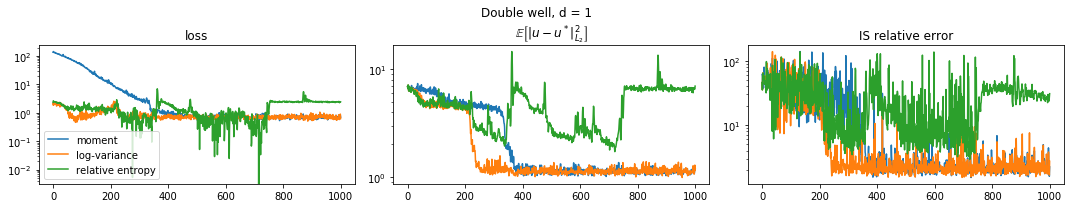

In [20]:
fig = plot_loss_logs('Double well', models[:3])

In [96]:
thresh = 0.01

grad_stats = {}

for model in models[:3]:
    grad_stats[model.name] = {}
    grad_stats[model.name]['gradient_log'] = model.gradient_log
    selection = pt.abs(pt.mean(model.gradient_log, 1)) > thresh
    selection_ = pt.repeat_interleave(selection[:, np.newaxis, :], M, dim=1)
    gradients = copy.deepcopy(model.gradient_log)
    gradients[~selection_] = 0
    grad_stats[model.name]['variance'] = pt.var(gradients, 1)
    grad_stats[model.name]['rel_error'] = pt.sqrt(grad_stats[model.name]['variance']) / pt.mean(gradients, 1)
    grad_stats[model.name]['rel_error'][grad_stats[model.name]['rel_error'] != grad_stats[model.name]['rel_error']] = 0

In [97]:
grad_stats_list = {}
for model_name in grad_stats:
    grad_stats_list[model_name] = {}
    for key in grad_stats[model_name]:
        grad_stats_list[model_name][key] = grad_stats[model_name][key].cpu().numpy().tolist()
    
#filename = 'variance_gradients_paper.json'
#with open('logs/%s' % filename, 'w') as f:
#    json.dump(grad_stats_list, f)

In [93]:
# save_exp_logs(models, 'paper/double_well_gradient_variances')

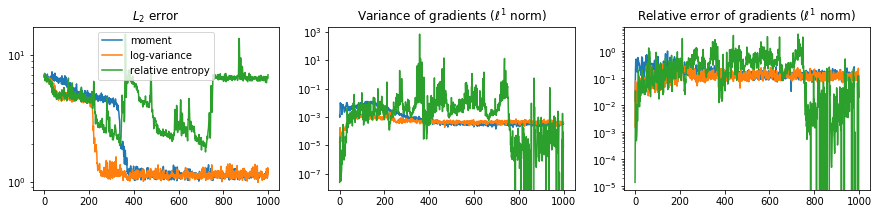

In [71]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

ax[0].set_title(r'$L_2$ error')
ax[1].set_title(r'Variance of gradients ($\ell^1 $ norm)')
ax[2].set_title(r'Relative error of gradients ($\ell^1 $ norm)')
for model in models[:3]:
    ax[0].plot(model.u_L2_loss, label=model.name)
    ax[1].plot(pt.mean(pt.abs(grad_stats[model.name]['variance']), 1), label=model.name)
    ax[2].plot(pt.mean(pt.abs(grad_stats[model.name]['rel_error']), 1), label=model.name)

ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')

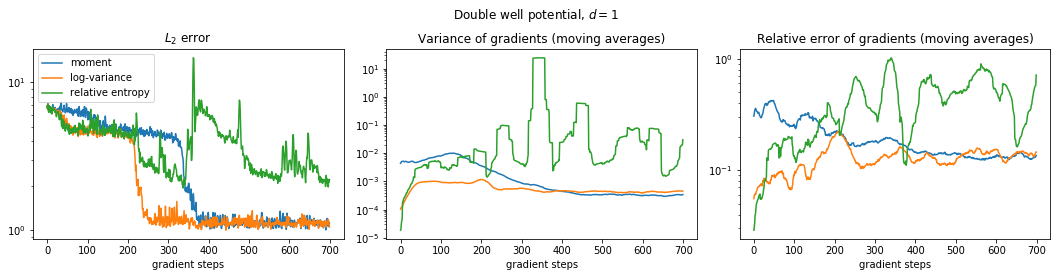

In [90]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

end = 700

ax[0].set_title(r'$L_2$ error')
ax[1].set_title(r'Variance of gradients (moving averages)')
ax[2].set_title(r'Relative error of gradients (moving averages)')
for model in models[0:3]:
    ax[0].plot(model.u_L2_loss[:end], label=model.name)
    l_1_var = pt.mean(pt.abs(grad_stats[model.name]['variance']), 1)
    l_1_rel_error = pt.mean(pt.abs(grad_stats[model.name]['rel_error']), 1)
    W = 30
    ma_l_1_var = pt.zeros(L - W - (1000 - end - 30))
    ma_l_1_rel_error = pt.zeros(L - W - (1000 - end - 30))
    for w in range(0, L - W - (1000 - end - 30)):
        ma_l_1_var[w] = pt.mean(l_1_var[w:w + W])
        ma_l_1_rel_error[w] = pt.mean(l_1_rel_error[w:w + W])
        #ma_l_1_var[w] = pt.mean(l_1_var[w - W:w])
        #ma_l_1_rel_error[w] = pt.mean(l_1_rel_error[w - W:w])
    ax[1].plot(ma_l_1_var, label=model.name)
    ax[2].plot(ma_l_1_rel_error, label=model.name)

fig.suptitle(r'Double well potential, $d = 1$')
ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[0].set_xlabel('gradient steps')
ax[1].set_xlabel('gradient steps')
ax[2].set_xlabel('gradient steps')
fig.tight_layout(rect=[0, 0.03, 1, 0.93])
#fig.savefig('img/variance_of_gradients_double_well_4.pdf')